<a href="https://colab.research.google.com/github/Tusshar10/React-Projects/blob/master/yackathon_stmicro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip

--2025-03-06 15:46:29--  https://github.com/STMicroelectronics/stm32ai/raw/master/AI_resources/HAR/dataset.zip
Resolving github.com (github.com)... 140.82.116.3
Connecting to github.com (github.com)|140.82.116.3|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://github.com/STMicroelectronics/stm32ai-wiki/raw/master/AI_resources/HAR/dataset.zip [following]
--2025-03-06 15:46:29--  https://github.com/STMicroelectronics/stm32ai-wiki/raw/master/AI_resources/HAR/dataset.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/STMicroelectronics/stm32ai-wiki/master/AI_resources/HAR/dataset.zip [following]
--2025-03-06 15:46:29--  https://raw.githubusercontent.com/STMicroelectronics/stm32ai-wiki/master/AI_resources/HAR/dataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecti

In [2]:
!unzip -n dataset.zip

Archive:  dataset.zip
   creating: dataset/
  inflating: dataset/LICENSE         
  inflating: dataset/README.md       
   creating: dataset/running/
  inflating: dataset/running/running_01_26Hz_4g_mg.csv  
  inflating: dataset/running/running_02_26Hz_4g_mg.csv  
  inflating: dataset/running/running_03_26Hz_4g_mg.csv  
  inflating: dataset/running/running_04_26Hz_4g_mg.csv  
  inflating: dataset/running/running_05_26Hz_4g_mg.csv  
  inflating: dataset/running/running_06_26Hz_4g_mg.csv  
  inflating: dataset/running/running_07_26Hz_4g_mg.csv  
  inflating: dataset/running/running_08_26Hz_4g_mg.csv  
  inflating: dataset/running/running_09_26Hz_4g_mg.csv  
  inflating: dataset/running/running_10_26Hz_4g_mg.csv  
  inflating: dataset/running/running_12_26Hz_4g_mg.csv  
  inflating: dataset/running/running_13_26Hz_4g_mg.csv  
  inflating: dataset/running/running_14_26Hz_4g_mg.csv  
  inflating: dataset/running/running_15_26Hz_4g_mg.csv  
  inflating: dataset/running/running_16_26Hz_4g_mg.c

In [29]:
import glob
import numpy as np
import re  # To use regular expressions for extracting numbers from filenames

# Load data into memory
labels = ['stationary', 'walking', 'running']
x_recordings = []
y_recordings = []
recordings_filenames = []

for i, label in enumerate(labels):
    filenames = glob.glob('dataset/' + label + '/*.csv')
    for filename in filenames:
        # Extract the file number from the filename using regex
        match = re.search(r'_(\d{2})_', filename)  # Looks for a pattern like _01_, _02_, etc.
        if match:
            file_number = int(match.group(1))
            if 1 <= file_number <= 18:  # Only keep files where the number is between 01 and 18
                data = np.loadtxt(filename, delimiter=',')
                x_recordings.append(data)
                y_recordings.append(i)
                recordings_filenames.append(filename)

x_recordings = np.array(x_recordings).reshape(len(x_recordings), -1, 3)
y_recordings = np.array(y_recordings)

print(x_recordings.shape)
print(y_recordings.shape)


(53, 1000, 3)
(53,)


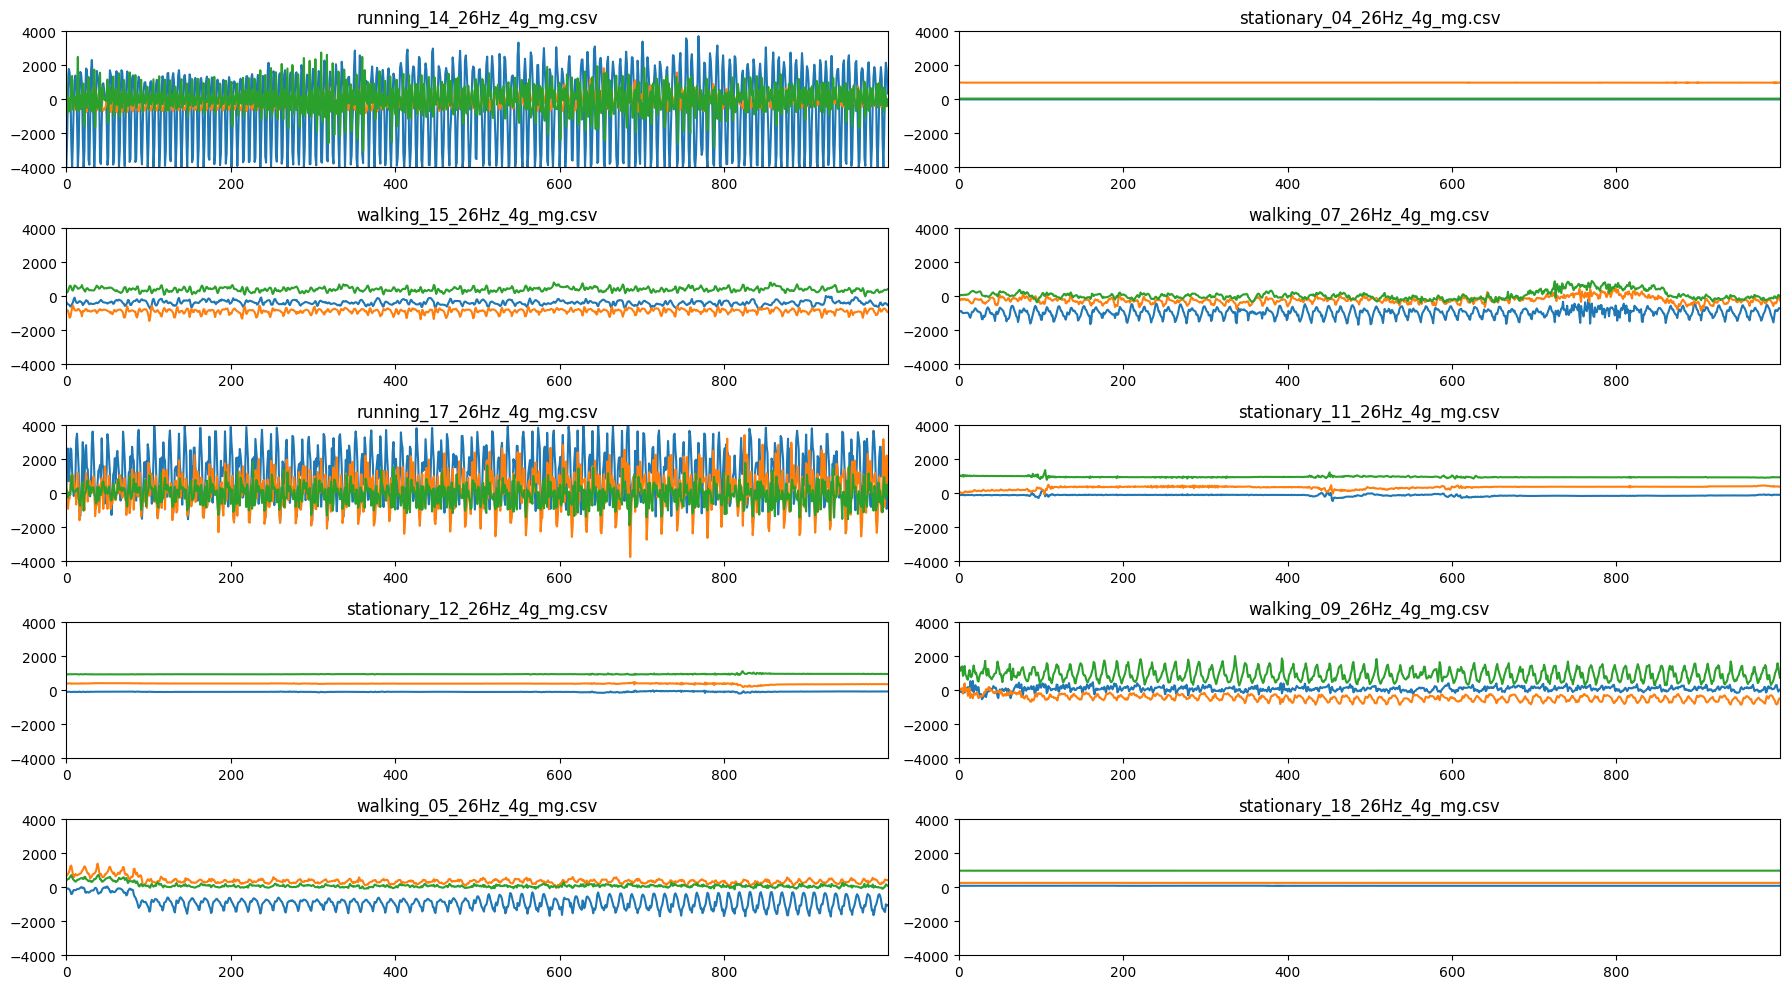

In [30]:

import random
import matplotlib.pyplot as plt
%matplotlib inline

# Plot some captures
random.seed(10)
unique_rands = random.sample(range(len(x_recordings)), 10)
plt.figure(figsize=(18, 10))
for i, n in enumerate(unique_rands):
    plt.subplot(5, 2, i + 1)
    plt.margins(x=0, y=-0.25)
    plt.plot(x_recordings[n])
    plt.ylim(-4000, 4000)  # 4000 mg acc. range
    plt.title(recordings_filenames[n].split('/')[-1])
plt.tight_layout()
plt.show()


In [31]:
import numpy as np

def frame(x, frame_len, hop_len):
    '''Slice a 3D data array into (overlapping) frames.

    Example
    --------
    >>> x = np.array([[0, 1, 2],
                      [10, 11, 12],
                      [20, 21, 22],
                      [30, 31, 32],
                      [40, 41, 42],
                      [50, 51, 52],
                      [60, 61, 62]])
    >>> frames = x.frame(x, 3, 2)
    >>> x.shape
    (7, 3)
    >>> frames.shape
    (3, 3, 3)
    '''

    assert(x.shape == (len(x), 3))
    assert(x.shape[0] >= frame_len)
    assert(hop_len >= 1)

    n_frames = 1 + (x.shape[0] - frame_len) // hop_len
    shape = (n_frames, frame_len, x.shape[1])
    strides = ((hop_len * x.strides[0],) + x.strides)
    return np.lib.stride_tricks.as_strided(x, shape=shape, strides=strides)

x_frames = []
y_frames = []
for i in range(x_recordings.shape[0]):
    # frames = frame(x_recordings[i], 26, 26) # no overlap
    frames = frame(x_recordings[i], 26, 13) # 50% overlap
    x_frames.append(frames)
    y_frames.append(np.full(frames.shape[0], y_recordings[i]))

print(np.array(x_frames).shape)
x_frames = np.concatenate(x_frames)
y_frames = np.concatenate(y_frames)
print(x_frames.shape)

# Each output label is an integer between 0 and 2:
print(y_frames.shape)
print(labels)

(53, 75, 26, 3)
(3975, 26, 3)
(3975,)
['stationary', 'walking', 'running']


In [32]:
x_frames=x_frames/4000

In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from google.colab import drive
import os

# Mount Google Drive
drive.mount('/content/drive')

# Set directory to save models
save_path = "/content/drive/MyDrive/cgan_model/"
os.makedirs(save_path, exist_ok=True)

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# Load preprocessed data
x_frames = torch.tensor(x_frames, dtype=torch.float32).to(device)
y_frames = torch.tensor(y_frames, dtype=torch.long).to(device)

# Create DataLoader
dataset = TensorDataset(x_frames, y_frames)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define the Generator with LSTM
class Generator(nn.Module):
    def __init__(self, noise_dim, label_dim, hidden_dim, output_dim):
        super(Generator, self).__init__()
        self.lstm = nn.LSTM(noise_dim + label_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, noise, labels):
        x = torch.cat((noise, labels), dim=2)
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out)

# Define the Discriminator with LSTM
class Discriminator(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim + label_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, data, labels):
        x = torch.cat((data, labels), dim=2)
        lstm_out, _ = self.lstm(x)
        return torch.sigmoid(self.fc(lstm_out[:, -1, :]))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [40]:
len(labels)

3

In [41]:
# Set parameters
noise_dim = 100
label_dim = 3
hidden_dim = 128
input_dim = x_frames.shape[2]  # Fix input dimension for LSTM

# Initialize models
generator = Generator(noise_dim, label_dim, hidden_dim, input_dim).to(device)
discriminator = Discriminator(input_dim, label_dim, hidden_dim).to(device)

# Loss and optimizers
criterion = nn.BCELoss()
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    for real_data, labels in dataloader:
        batch_size = real_data.shape[0]
        real_labels = torch.nn.functional.one_hot(labels, label_dim).float().unsqueeze(1).repeat(1, real_data.shape[1], 1).to(device)

        # Train Discriminator
        noise = torch.randn(batch_size, real_data.shape[1], noise_dim, device=device)
        fake_data = generator(noise, real_labels)

        real_preds = discriminator(real_data, real_labels)
        fake_preds = discriminator(fake_data.detach(), real_labels)

        d_loss = criterion(real_preds, torch.ones_like(real_preds)) + \
                criterion(fake_preds, torch.zeros_like(fake_preds))

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        fake_preds = discriminator(fake_data, real_labels)
        g_loss = criterion(fake_preds, torch.ones_like(fake_preds))

        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

    print(f"Epoch [{epoch+1}/{num_epochs}] - D Loss: {d_loss.item():.4f} - G Loss: {g_loss.item():.4f}")

# Save the trained models to Google Drive
torch.save(generator.state_dict(), os.path.join(save_path, "generator.pth"))
torch.save(discriminator.state_dict(), os.path.join(save_path, "discriminator.pth"))

print("Training complete and models saved in Google Drive.")


Epoch [1/100] - D Loss: 1.3841 - G Loss: 0.6989
Epoch [2/100] - D Loss: 1.3997 - G Loss: 0.6874
Epoch [3/100] - D Loss: 1.3880 - G Loss: 0.7138
Epoch [4/100] - D Loss: 1.2968 - G Loss: 0.8943
Epoch [5/100] - D Loss: 1.4476 - G Loss: 0.8784
Epoch [6/100] - D Loss: 0.8849 - G Loss: 1.2745
Epoch [7/100] - D Loss: 1.3862 - G Loss: 0.7163
Epoch [8/100] - D Loss: 1.3106 - G Loss: 0.8925
Epoch [9/100] - D Loss: 1.1890 - G Loss: 0.7807
Epoch [10/100] - D Loss: 1.3408 - G Loss: 0.8772
Epoch [11/100] - D Loss: 1.3934 - G Loss: 0.7366
Epoch [12/100] - D Loss: 1.3134 - G Loss: 0.7703
Epoch [13/100] - D Loss: 1.3619 - G Loss: 0.7859
Epoch [14/100] - D Loss: 1.3842 - G Loss: 0.6595
Epoch [15/100] - D Loss: 1.3854 - G Loss: 0.6966
Epoch [16/100] - D Loss: 1.3818 - G Loss: 0.6933
Epoch [17/100] - D Loss: 1.3677 - G Loss: 0.7415
Epoch [18/100] - D Loss: 1.3563 - G Loss: 0.7954
Epoch [19/100] - D Loss: 1.3977 - G Loss: 0.7397
Epoch [20/100] - D Loss: 1.4083 - G Loss: 0.5779
Epoch [21/100] - D Loss: 1.39

In [44]:
def denormalize_data(normalized_data, scale_factor=4000):
    return normalized_data * scale_factor

In [45]:
generator.load_state_dict(torch.load(os.path.join(save_path, "generator.pth")))
generator.eval()

# Generate new data
num_samples = 5
noise = torch.randn(num_samples, x_frames.shape[1], noise_dim, device=device)
labels = torch.randint(0, label_dim, (num_samples,), device=device)
one_hot_labels = torch.nn.functional.one_hot(labels, label_dim).float().unsqueeze(1).repeat(1, x_frames.shape[1], 1).to(device)

fake_data = generator(noise, one_hot_labels).cpu().detach().numpy()

# Print generated data with corresponding labels
print("Generated Data with Labels:")
activity_labels = ['stationary', 'walking', 'running']

for i in range(num_samples):
    label_idx = labels[i].item()
    if 0 <= label_idx < len(activity_labels):  # Ensure valid index
        print(f"Label: {label_idx} ({activity_labels[label_idx]})")
    else:
        print(f"Label: {label_idx} (Unknown)")
    denormalized_fake_data = denormalize_data(fake_data[i])
    print(denormalized_fake_data)
    print("-")

Generated Data with Labels:
Label: 2 (running)
[[ -186.1974      11.66024    -87.77101 ]
 [-1167.5798    -542.09705   -764.9329  ]
 [-1052.5627     -68.43304   -452.83182 ]
 [  264.0703    -131.00722    260.4529  ]
 [ 2285.9768    -463.38385    615.6097  ]
 [ 2648.5352   -2297.0845    -183.3163  ]
 [ 1707.2377   -1816.7247     -11.779234]
 [   12.316339  -850.5747     -63.331738]
 [ -103.06745    245.2089     854.31946 ]
 [ 1446.7375     -85.69801   1252.1459  ]
 [ 2303.5288   -1619.3279     801.1751  ]
 [ 2286.452    -2362.6436    -348.47455 ]
 [ 2095.6567   -2089.2095     625.9675  ]
 [ 1471.5199   -2070.1057     -26.921316]
 [ 1289.301    -1117.921      454.2781  ]
 [ 1764.0619   -1251.2383     289.35324 ]
 [ 1866.8248    -922.0889     194.24284 ]
 [ 1643.9258   -1680.7743     -95.3679  ]
 [ 1873.6765   -1141.8003     478.82455 ]
 [ 2591.1226   -1052.7173     413.61887 ]
 [ 2318.748    -1578.3481    -361.92078 ]
 [ 2223.9275    -668.47815    236.37079 ]
 [ 2677.589     -875.2592    

<ipython-input-45-870c4fcb73d6>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(os.path.join(save_path, "generator.pth")))


In [28]:
labels

tensor([2, 0, 0, 3, 3], device='cuda:0')